# Bu proje "aiseclab.org" destekleri ile hazırlanmıştır.

# AMAÇ: Makine Öğrenmesi ile Zararlı WAF Sorgularının Sınıflandırılması

Veri setimiz 1.31 milyon meşru ve kötü niyetli alan adı URL'si örneğinden oluşmaktadır, bu not defterinde önce veri setini inceleyeceğiz ve ardından kötü niyetli ve meşru URL'leri en iyi şekilde tahmin edecek bir sınıflandırıcı modeli eğiteceğiz.

In [2]:
import numpy as np   # çok boyutlu dizi ve matris
import pandas as pd  # veri manipülasyonu ve analizi
import seaborn as sns # Çekici ve bilgilendirici istatistiksel grafikler çizmek için üst düzey arayüz 
import matplotlib.pyplot as plt # Çizimleri uygulamalara yerleştirmek için nesne yönelimli bir API sağlar
%matplotlib inline 
# Matplotlib'in arka ucunu 'satır içi' arka uca ayarlar.

import urllib  # URL'lerle çalışmak için kullanın ve web üzerinden veri getirmenize olanak tanır.
import os # İşletim sistemiyle etkileşim kurmanın bir yolunu sunarak dosya ve dizinlerde gezinmenize, oluşturmanıza, silmenize ve değiştirmenize olanak tanır.
import re # dize arama ve manipülasyon
import pickle # Python nesne yapılarını serileştirmek (kaydetmek) ve serileştirmeyi kaldırmak (yüklemek).
import nltk # insan dili verileriyle (metin) çalışmak.
import string # bir modül çeşitli dize sabitleri ve yardımcı fonksiyonlar içerir.
from wordcloud import WordCloud #  Kelime bulutları oluşturmak için kullanın.
import time # 
from nltk.tokenize import RegexpTokenizer # Regexler kullanarak metinleri tokenleştirme.
from nltk.stem import SnowballStemmer  # Kök bulucu.
from nltk.corpus import stopwords # İşlevsiz kelimeleri temizlemek.
from collections import Counter # Kelime sayacı.
from PIL import Image # not defterindeki görüntüleri alma
from sklearn.model_selection import train_test_split, cross_val_score # veri dizilerini eğitim ve test alt kümelerine bölmek için kullanın.
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # sınıflandırma modellerinin performansını değerlendirmek için kullanın.
from sklearn.preprocessing import StandardScaler # ortalamayı kaldırarak ve birim varyansa ölçeklendirerek özellikleri standartlaştırmak için kullanın.

# Kesinlik, geri çağırma, AUC, ROC eğrisi ve F1 puanı gibi çeşitli değerlendirme metriklerini hesaplamak için gerekli modülleri içe aktarın.
from sklearn.metrics import precision_recall_curve, recall_score, auc, roc_auc_score, roc_curve, precision_score, f1_score

# Sınıf dengesizliğini ele almak için imblearn'den Sentetik Azınlık Aşırı Örnekleme Tekniğini (SMOTE) içe aktarın.
from imblearn.over_sampling import SMOTE

# Çapraz doğrulama skoru
from sklearn.model_selection import cross_val_score

# Hiperparametre arama.
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression # iyi veya kötüyü tahmin etmek için algo kullanımı
from sklearn.ensemble import RandomForestClassifier # iyi veya kötüyü tahmin etmek için algo kullanımı
from sklearn.tree import DecisionTreeClassifier     # iyi veya kötüyü tahmin etmek için algo kullanımı
from xgboost import XGBClassifier                   # iyi veya kötüyü tahmin etmek için algo kullanımı

# Bazı uyarıları gizlemek için
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Metkileri görüntüleme.
from mlxtend.plotting import plot_confusion_matrix
from scikitplot.metrics import plot_cumulative_gain, plot_precision_recall, plot_roc_curve

# Grafiklerin kaydedileceği dizin
PROJECT_ROOT_DIR = "waf/website"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
np.random.seed(42)

# Grafikleri kaydeden fonksiyon
def save_fig(title):
    path = os.path.join(IMAGES_PATH, title + ".png")
    plt.tight_layout()
    plt.savefig(path, format="png", dpi=300)

# Keşifsel Veri Analizi

## Amaç :

Verilerinizi olabildiğince iyi anlayın (küçük bir ileri adım, büyük bir geri adımdan daha iyidir). İlk modelleme stratejisini geliştirin.

   #### Sütun Analizi:
   
   * Hedef değişken:------------> label

   *  Satır ve Sütun Sayısı:-----------> (1310707, 2)
        * "label" sütunu 2 kategorili tahmin sütunudur.
           * A. 0 - bu, URL'lerin kötü amaçlı öğeler içermediği anlamına gelir.
           * B. 1 – bu, URL'lerin kötü amaçlı öğeler içerdiği anlamına gelir.

   *  Değişken türleri:-------------> int64

   *  Kayıp veriler:--> 0% of NAN

###### NOT :  Veri setimiz dengesiz. Veri kümesini aşırı örneklemek için SMOTE kullanacağız.

"loadFile" fonksiyonu ".txt" uzansıtısındaki verisetinin her bir satırını okuyarak liste tipinde bir eleman olarak döndürür.

In [3]:
def loadFile(name):
    directory = str(os.getcwd())
    filepath = os.path.join(directory, name)
    with open(filepath,'r') as f:
        data = f.readlines()
    data = list(set(data))
    result = []
    for d in data:
        d = str(urllib.parse.unquote(d))
        result.append(d)
    return result

Zararlı ve zararsız isteklerin bulunduğu dosyaları "loadFile" fonksiyonu ile okuyarak değişkenlere liste tipinde kaydettik.

In [4]:
badQueries = loadFile("waf/website/datasets/badqueries.txt")
goodQueries = loadFile("waf/website/datasets/goodqueries.txt")

Liste tipindeki bu verileri "DataFrame" nesnesine çevirdik.

In [5]:
bad_df = pd.DataFrame(badQueries)
good_df = pd.DataFrame(goodQueries)

Sütun ismi olarak da "query" ayarladık.

In [6]:
bad_df.columns = ["query"]
good_df.columns = ["query"]

In [7]:
bad_df.head()

,query
0,/main.php?stuff='\x0asleep\x098\x09#\n
1,/javascript/program.exe\n
2,"<img+src=""http://localhost"">\n"
3,/javascript/html.exe\n
4,/scriptpage/source/includes/load_forum.php?mfh...


In [8]:
good_df.head()

,query
0,/patrickm/\n
1,/javascript/backdoor.js\n
2,/syriablog/\n
3,/mailcon1/\n
4,/javascript/msie.manifest\n


Verileri okuduktan sonra her bir satır sonunda "\n" ifadesi olduğunu gördük. "clean_newline" fonksiyonu ile bu ifadeyi temizledik. 

In [9]:
def clean_newline(column):
    column[:-2]
    return column[:-2]

In [10]:
good_df["query"] = good_df["query"].apply(clean_newline)

In [11]:
good_df.head()

,query
0,/patrickm
1,/javascript/backdoor.j
2,/syriablog
3,/mailcon1
4,/javascript/msie.manifes


In [12]:
bad_df["query"] = bad_df["query"].apply(clean_newline)

In [13]:
bad_df.head()

,query
0,/main.php?stuff='\x0asleep\x098\x09
1,/javascript/program.ex
2,"<img+src=""http://localhost"""
3,/javascript/html.ex
4,/scriptpage/source/includes/load_forum.php?mfh...


Elle zararsız sorguları "label" sütunda 0, zararlı sorguları "label" sütununda 1 olarak işaretledik.

In [14]:
good_df["label"] = 0
bad_df["label"] = 1

In [15]:
good_df.shape[0] + bad_df.shape[0]

1310707

Zararlı ve zararsız verisetlerini birleştirdik.

In [16]:
df = pd.concat([good_df, bad_df], axis=0)

In [17]:
df.shape[0]

1310707

In [18]:
df.head()

,query,label
0,/patrickm,0
1,/javascript/backdoor.j,0
2,/syriablog,0
3,/mailcon1,0
4,/javascript/msie.manifes,0


Verisetini karıştırdık.

In [19]:
df = df.sample(frac=1).reset_index(drop=True)

In [20]:
df.head()

,query,label
0,/sbook1f,0
1,/376491,0
2,/51310374,0
3,/juliobrasil3,0
4,/08hearing,0


Verisetinin %3.4'ü zararlı %96.6'sı ise zararsız isteklerden oluşuyor. Veriseti oldukça düzensiz.

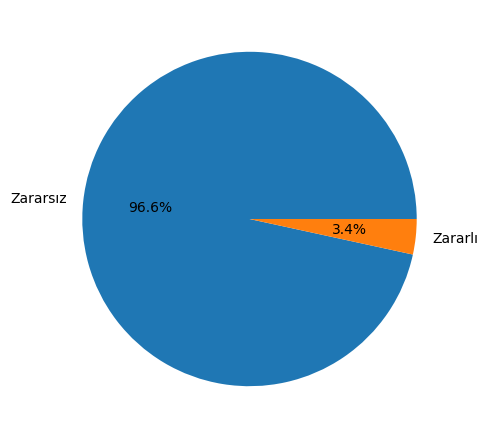

In [21]:
total_0, total_1 = len(df[df["label"] == 0]), len(df[df["label"] == 1])
label = np.array(["Zararsız", "Zararlı"])
values = np.array([total_0, total_1])
plt.figure(figsize=(5, 5))
plt.pie(values, labels=label, autopct="%.1f%%")
save_fig("total_db")
plt.show()

Bazı satırlarda verilerin başında "/" var iken bazılarında yok. Bu yüzden tüm satır başlarından "/" ifadesini kaldırdık. 

In [22]:
def clear_first_char(column):
    if column.startswith("/"):
        return column[1:]
    else:
        return column

In [23]:
df["query"] = df["query"].apply(clear_first_char)

In [24]:
df.head()

,query,label
0,sbook1f,0
1,376491,0
2,51310374,0
3,juliobrasil3,0
4,08hearing,0


# Preprocess

Gelen isteğin bir XSS saldırısı olup olmadığını tespit etmek için JavaScript fonksiyonlarını gelen istek içerisinde aradık. Eğer gelen istek içerisinde JavaScript fonksiyonu var ise bu isteği zararlı olarak işaretledik.

In [25]:
def xss_check(input_string):
    input_string = urllib.parse.unquote(input_string)
    xss_pattern=re.compile(r'(<|>|&lt;|&gt;|script|alert|document\.|onload\=|onerror\=|eval\(|expression\(|prompt\(|confirm\()')
    if xss_pattern.search(input_string.split("/")[-1]):
        return 1
    else:
        return 0

In [26]:
df["is_xss"] = df["query"].apply(xss_check)

In [27]:
df[df["is_xss"] == 1].head()

,query,label,is_xss
7,miz4r5hz.html?<meta http-equiv=set-cookie cont...,1,1
81,<script>alert(document.head.childNodes[3].text...,1,1
203,admin/common/script.legacy.j,1,1
222,moodle/filter/tex/texed.php?formdata=foo&pathn...,1,1
354,zqqemp6j.pl?<script>cross_site_scripting.nasl<...,1,1


Gelen isteğin bir LFI (Local File Inclusion) saldırısı olup olmadığını tespit etmek için gelen istek içerisinde "../", ".../" gibi başlayan ifadelerini aradık. Eğer gelen istekte bu ifadeler varsa zararlı olarak işaretledik.

In [28]:
def lfi_check(input_string):
    input_string = urllib.parse.unquote(input_string)
    lfi_pattern = re.compile(r'(file\:\/\/|(\.\.\/)|(\.\.\\))')
    if "=" in input_string.split("/")[-1]:
        if lfi_pattern.search(input_string.split("/")[-1].split("=", 1)[1]):
            return 1
        else:
            return 0
    elif lfi_pattern.search(input_string.split("/")[-1]):
        return 1
    else:
        return 0

In [29]:
"scripts/misc/audio.php?recording=../version.in".split("=", 1)

['scripts/misc/audio.php?recording', '../version.in']

In [30]:
df["is_lfi"] = df["query"].apply(lfi_check)

In [31]:
df[df["is_lfi"] == 1].sample(5)

,query,label,is_xss,is_lfi
1191621,...\...\...\...\...\{FILE,1,0,1
464635,...\{FILE,1,0,1
580565,servlet/com.newatlanta.servletexec.jsp10servle...,1,0,1
814799,....\....\....\{FILE,1,0,1
631427,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,1,0,1


Gelen isteğin bir OSi (OS Command Injection) saldırısı olup olmadığını tespit etmek için gelen istek içerisinde "||, \$(, ;" gibi başlayan ifadelerini aradık. Eğer gelen istekte bu ifadeler varsa zararlı olarak işaretledik.

In [32]:
def command_injection_check(input_string):
    input_string = urllib.parse.unquote(input_string)
    cmd_injection_pattern = re.compile(r'(;|\||`|\$\(|\$\{)')

    if cmd_injection_pattern.search(input_string):
        return 1
    else:
        return 0

In [33]:
df["is_oci"] = df["query"].apply(command_injection_check)

In [34]:
df[df["is_oci"] == 1].sample(5)

,query,label,is_xss,is_lfi,is_oci
944348,"fnwhrxyd.kspx?<img src=""javascript:alert(cross...",1,1,0,1
12633,"ygkjkngd.kspx?<script>document.cookie=""testnag...",1,1,0,1
929438,| [ 5 -ne $(echo MUMUQI | tr -d '\n' | wc -c) ...,1,0,0,1
1152970,')print(`echo RUXOHA`.`echo $((74+92))`.`echo ...,1,0,0,1
996334,cgi-bin/nmap.php?target=|ipconfig /al,0,0,0,1


Gelen isteğin bir SQLi (SQL Injection) saldırısı olup olmadığını tespit etmek için gelen istek içerisinde SQL sorgu ifadelerini aradık. Eğer gelen istekte bu ifadeler varsa zararlı olarak işaretledik.

In [35]:
def sql_injection_check(input_string):
    input_string = urllib.parse.unquote(input_string)
    sqli_pattern = re.compile(r'(\b(SELECT|INSERT|UPDATE|DELETE|FROM|WHERE|AND|OR|UNION|ALL|EXEC|EXECUTE|DECLARE|CAST)\b)')

    if sqli_pattern.search(input_string):
        return 1
    else:
        return 0

In [36]:
df["is_sqli"] = df["query"].apply(sql_injection_check)

In [37]:
df[df["is_sqli"] == 1].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli
392132,x' AND userid IS NULL; --,1,0,0,1,1
749945,WHERE 1=1 AND 1=0-,1,0,0,0,1
985743,SELECT schemaname FROM syscat.schemata,1,0,0,0,1
624159,323) /*!00000AND 3244=4853 AND (6013=6013*,1,0,0,0,1
617074,AND 7300=7300 AND ('pKlZ'='pKl,1,0,0,0,1


"urllen" fonksiyonu sorgunun uzunluğunu hesaplar. Bir SQL Injection saldırısı çok uzun ifadelerden oluşabilir. Bir dizin tarama saldırısı, wordlist dosyalarından gelen ifadelerle uzun sorgular oluşturabilir. Bu nedenle, sorgu uzunluğunun hesaplanması bunları yakalamada etkilidir.

In [38]:
def urllen(url):
    return len(url)

In [39]:
df["url_len"] = df["query"].apply(urllen)

In [40]:
df.head()

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len
0,sbook1f,0,0,0,0,0,7
1,376491,0,0,0,0,0,6
2,51310374,0,0,0,0,0,8
3,juliobrasil3,0,0,0,0,0,12
4,08hearing,0,0,0,0,0,9


Noktalama işaretleri çeşitli web saldırılarında gönderilen istekler içerisinde bolca kullanılır. Bunun için her bir noktalama işaretinin adetini tek tek hesapladık.

In [41]:
def semicolon_count(url):
    url = urllib.parse.unquote(url)
    return url.count(";")

In [42]:
df["semicolon_count"] = df["query"].apply(semicolon_count)

In [43]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count
1159692,linux_review-index,0,0,0,0,0,18,0
855232,57610427,0,0,0,0,0,8,0
244954,define-fluconazole,0,0,0,0,0,18,0
975591,affinity1,0,0,0,0,0,9,0
881381,synkronizer,0,0,0,0,0,11,0


In [44]:
def underscore_count(url):
    url = urllib.parse.unquote(url)
    return url.count("_")

In [45]:
df["underscore_count"] = df["query"].apply(underscore_count)

In [46]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count
198713,javascript/cgm-web.jp,0,0,0,0,0,21,0,0
278417,javascript/rdf.tes,0,0,0,0,0,18,0,0
542413,"82q7ywa8.pl?<script>document.cookie=""testpwew=...",1,1,0,1,0,60,1,0
728315,examples/servlets/servlet/index.php?x=browse&c...,1,0,0,0,0,133,0,3
981675,q2314359,0,0,0,0,0,8,0,0


In [47]:
def questionmark_count(url):
    url = urllib.parse.unquote(url)
    return url.count("?")

In [48]:
df["questionmark_count"] = df["query"].apply(questionmark_count)

In [49]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count
927912,javascript/nav.ta,0,0,0,0,0,17,0,0,0
125285,tradesecret,0,0,0,0,0,11,0,0,0
1013362,top-downloads,0,0,0,0,0,13,0,0,0
63120,david-beckham_16jpg,0,0,0,0,0,19,0,1,0
697576,subscriptions.zi,1,1,0,0,0,16,0,0,0


In [50]:
def equal_count(url):
    url = urllib.parse.unquote(url)
    return url.count("=")

In [51]:
df["equal_count"] = df["query"].apply(equal_count)

In [52]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count
188966,javascript/log.ba,0,0,0,0,0,17,0,0,0,0
950478,ip_fil4,0,0,0,0,0,7,0,1,0,0
93172,aoe2demo,0,0,0,0,0,8,0,0,0,0
1302889,exchange/lib/getrend.in,0,0,0,0,0,23,0,0,0,0
1184598,677616,0,0,0,0,0,6,0,0,0,0


In [53]:
def and_count(url):
    url = urllib.parse.unquote(url)
    return url.count("&")

In [54]:
df["and_count"] = df["query"].apply(equal_count)

In [55]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count
186063,javascript/sync.r,0,0,0,0,0,17,0,0,0,0,0
546062,article_2925,0,0,0,0,0,12,0,1,0,0,0
337762,q_skin99,0,0,0,0,0,8,0,1,0,0,0
205885,wisconsinsummerjobs,0,0,0,0,0,19,0,0,0,0,0
83451,humvsdog,0,0,0,0,0,8,0,0,0,0,0


In [56]:
def or_count(url):
    url = urllib.parse.unquote(url)
    return url.count("|")

In [57]:
df["or_count"] = df["query"].apply(or_count)

In [58]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count
313832,000124469,0,0,0,0,0,9,0,0,0,0,0,0
1291347,bedroom_21,0,0,0,0,0,10,0,1,0,0,0,0
1052074,yvvf50,0,0,0,0,0,6,0,0,0,0,0,0
108489,javascript/get.md,0,0,0,0,0,17,0,0,0,0,0,0
1184055,quote-fast,0,0,0,0,0,10,0,0,0,0,0,0


In [59]:
df.head()

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count
0,sbook1f,0,0,0,0,0,7,0,0,0,0,0,0
1,376491,0,0,0,0,0,6,0,0,0,0,0,0
2,51310374,0,0,0,0,0,8,0,0,0,0,0,0
3,juliobrasil3,0,0,0,0,0,12,0,0,0,0,0,0
4,08hearing,0,0,0,0,0,9,0,0,0,0,0,0


In [60]:
def dotcount(url):
    url = urllib.parse.unquote(url)
    return url.count(".")

In [61]:
df["dot_count"] = df["query"].apply(dotcount)

In [62]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count
832578,index.php?get=http://192.168.202.118:8080/zz5t...,0,0,0,0,0,54,0,0,1,1,1,0,4
160297,pinnacle-10,0,0,0,0,0,11,0,0,0,0,0,0,0
1116455,javascript/ver1.dum,0,0,0,0,0,19,0,0,0,0,0,0,1
971737,13024032,0,0,0,0,0,8,0,0,0,0,0,0,0
410777,smrtyfsi0070000071inv,0,0,0,0,0,21,0,0,0,0,0,0,0


In [63]:
def atcount(url):
    url = urllib.parse.unquote(url)
    return url.count("@")

In [64]:
df["at_count"] = df["query"].apply(atcount)

In [65]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count
972947,sports-fitness,0,0,0,0,0,14,0,0,0,0,0,0,0,0
300948,javascript/complaint.php,0,0,0,0,0,24,0,0,0,0,0,0,1,0
119562,system of a down - prison song,0,0,0,0,0,30,0,0,0,0,0,0,0,0
429287,discbusc173,0,0,0,0,0,11,0,0,0,0,0,0,0,0
544449,webtoolkit,0,0,0,0,0,10,0,0,0,0,0,0,0,0


Sorgu yapılan dosyanın hangi dizinde olduğunu önemlidir. Bu dosya çeşitli dizinler içerisine gizlenmiş olabilir. Bunun için elen sorgunun alt dizin sayısını hesapladık.

In [66]:
def subdircount(url):
    url = urllib.parse.unquote(url)
    parsed_url = urllib.parse.urlparse(url)
    subdirectory_path = len(parsed_url.path.strip("/").split("/"))
    return subdirectory_path

In [67]:
df["subdir_count"] = df["query"].apply(subdircount)

In [68]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count
1192881,1004359783,0,0,0,0,0,10,0,0,0,0,0,0,0,0,1
765508,q8312559,0,0,0,0,0,8,0,0,0,0,0,0,0,0,1
1125244,aitkenms,0,0,0,0,0,8,0,0,0,0,0,0,0,0,1
694530,trend_micro,0,0,0,0,0,11,0,1,0,0,0,0,0,0,1
535137,gdxlwjnlsr6i.cg,0,0,0,0,0,15,0,0,0,0,0,0,1,0,1


Parametreler üzerinden yapılan SQL Injection, XSS Injection gibi saldırıları yakalamak için sorgu uzunluğunu yakalamak gereklidir.

In [69]:
def query_len(url):
    parsed_url = urllib.parse.urlparse(url)
    if len(parsed_url.query) > 0:
        query_params = urllib.parse.parse_qs(parsed_url.query)
        query_string = "".join(f"{value[0]}" for key, value in query_params.items())    
        return len(query_string)
    else:
        return 0

In [70]:
df["query_len"] = df["query"].apply(query_len)

In [71]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len
1216263,nessus559518121.htm,0,0,0,0,0,19,0,0,0,0,0,0,1,0,1,0
447089,javascript/22.ke,0,0,0,0,0,16,0,0,0,0,0,0,1,0,2,0
874922,514797,0,0,0,0,0,6,0,0,0,0,0,0,0,0,1,0
299449,vindication_gifts,0,0,0,0,0,17,0,1,0,0,0,0,0,0,1,0
993203,book-img,0,0,0,0,0,8,0,0,0,0,0,0,0,0,1,0


Toplam parametre sayısı hesaplanır.

In [72]:
def param_count(url):
    parsed_url = urllib.parse.urlparse(url)
    query_params = urllib.parse.parse_qs(parsed_url.query)
    return len(query_params)

In [73]:
df["param_count"] = df["query"].apply(param_count)

In [74]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count
874235,140745,0,0,0,0,0,6,0,0,0,0,0,0,0,0,1,0,0
241791,chat.php?my[root]=http://192.168.202.96:8080/4...,0,0,0,0,0,65,0,0,3,2,2,0,4,0,1,47,1
1007477,showtopic,0,0,0,0,0,9,0,0,0,0,0,0,0,0,1,0,0
968985,michael moore about filesharing,0,0,0,0,0,31,0,0,0,0,0,0,0,0,1,0,0
108831,148446,0,0,0,0,0,6,0,0,0,0,0,0,0,0,1,0,0


Alt dizinler ve son dizindeki toplam harf ve rakam sayıları zararlı istekleri yakalamak için önemlidir.

In [75]:
def total_digits_in_url(url):
    total_digits = 0
    for text in list(map(str, "0123456789")):
        total_digits += url.lower().count(text)
        
    return total_digits

In [76]:
df["total_digits_url"] = df["query"].apply(total_digits_in_url)

In [77]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url
889508,javascript/zope.li,0,0,0,0,0,18,0,0,0,0,0,0,1,0,2,0,0,0
576856,javascript/theme.cspro,0,0,0,0,0,22,0,0,0,0,0,0,1,0,2,0,0,0
1070587,aeolusnighthawk,0,0,0,0,0,15,0,0,0,0,0,0,0,0,1,0,0,0
788831,140421,0,0,0,0,0,6,0,0,0,0,0,0,0,0,1,0,0,6
180675,light_dot,0,0,0,0,0,9,0,1,0,0,0,0,0,0,1,0,0,0


In [78]:
def total_letter_in_url(url):
    total_letter = 0
    for text in url:
        if text not in "0123456789":
            if text not in string.punctuation:
                total_letter += 1
        
    return total_letter

In [79]:
df["total_letter_url"] = df["query"].apply(total_letter_in_url)

In [80]:
tokenizer = RegexpTokenizer(r"[A-Za-z]+")

In [81]:
df["url_tokenized"] = df["query"].apply(lambda x: tokenizer.tokenize(x))

In [82]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized
340151,wifi_manager-2713,0,0,0,0,0,17,0,1,0,...,0,0,0,0,1,0,0,4,11,"[wifi, manager]"
209591,17842000-17842999,0,0,0,0,0,17,0,0,0,...,0,0,0,0,1,0,0,16,0,[]
324626,061207-132951,0,0,0,0,0,13,0,0,0,...,0,0,0,0,1,0,0,12,0,[]
402641,268880,0,0,0,0,0,6,0,0,0,...,0,0,0,0,1,0,0,6,0,[]
14425,announcethefreesoftwaretv,0,0,0,0,0,25,0,0,0,...,0,0,0,0,1,0,0,0,25,[announcethefreesoftwaretv]


In [83]:
stemmer = SnowballStemmer("english")

In [84]:
def stem_url(column):
    words = [stemmer.stem(word) for word in column if len(word) >= 3]
    return " ".join(words)

In [85]:
df["url_stemmed"] = df["url_tokenized"].apply(stem_url)

In [86]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed
1186677,javascript/hta.asm,0,0,0,0,0,18,0,0,0,...,0,1,0,2,0,0,0,16,"[javascript, hta, asm]",javascript hta asm
731915,fallingnukes,0,0,0,0,0,12,0,0,0,...,0,0,0,1,0,0,0,12,[fallingnukes],fallingnuk
806656,javascript/signed.pn,0,0,0,0,0,20,0,0,0,...,0,1,0,2,0,0,0,18,"[javascript, signed, pn]",javascript sign
1027894,454182,0,0,0,0,0,6,0,0,0,...,0,0,0,1,0,0,6,0,[],
1035233,cmpmgvse0050001846mrt,0,0,0,0,0,21,0,0,0,...,0,0,0,1,0,0,10,11,"[cmpmgvse, mrt]",cmpmgvse mrt


In [87]:
def total_digits_domain(url):
    parsed_url = urllib.parse.urlparse(url)
    clean_url = url.replace(parsed_url.query, "")
    path_components = [component for component in clean_url.split('/') if component]
    if path_components:
        until_last_directory = "".join([word for word in path_components[:-1]])
        return total_digits_in_url(until_last_directory)
    else:
        return 0

In [88]:
df["total_digits_domain"] = df["query"].apply(total_digits_domain)

In [89]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain
377701,javascript/check.pd,0,0,0,0,0,19,0,0,0,...,1,0,2,0,0,0,17,"[javascript, check, pd]",javascript check,0
640621,microsoft office 2004 de,0,0,0,0,0,24,0,0,0,...,0,0,1,0,0,4,20,"[microsoft, office, de]",microsoft offic,0
699947,monsterz,0,0,0,0,0,8,0,0,0,...,0,0,1,0,0,0,8,[monsterz],monsterz,0
1261467,20060111191416,0,0,0,0,0,14,0,0,0,...,0,0,1,0,0,14,0,[],,0
294094,stockbuy,0,0,0,0,0,8,0,0,0,...,0,0,1,0,0,0,8,[stockbuy],stockbuy,0


In [90]:
def total_letter_domain(url):
    parsed_url = urllib.parse.urlparse(url)
    clean_url = url.replace(parsed_url.query, "")
    path_components = [component for component in clean_url.split('/') if component]
    if path_components:
        until_last_directory = "".join([word for word in path_components[:-1]])
        return total_letter_in_url(until_last_directory)
    else:
        return 0

In [91]:
df["total_letter_domain"] = df["query"].apply(total_letter_domain)

In [92]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain
327320,3641706,0,0,0,0,0,7,0,0,0,...,0,1,0,0,7,0,[],,0,0
1133076,javascript/postpaid.dum,0,0,0,0,0,23,0,0,0,...,0,2,0,0,0,21,"[javascript, postpaid, dum]",javascript postpaid dum,0,10
613671,bittorrent_528801,0,0,0,0,0,17,0,1,0,...,0,1,0,0,6,10,[bittorrent],bittorr,0,0
931763,rand_mg350,0,0,0,0,0,10,0,1,0,...,0,1,0,0,3,6,"[rand, mg]",rand,0,0
1121189,audio-video-streaming,0,0,0,0,0,21,0,0,0,...,0,1,0,0,0,19,"[audio, video, streaming]",audio video stream,0,0


In [93]:
def total_digits_path(url):
    parsed_url = urllib.parse.urlparse(url)
    clean_url = url.replace(parsed_url.query, "")
    path_components = [component for component in clean_url.split('/') if component]
    if path_components:
        last_directory = "".join([word for word in path_components[-1]])
        return total_digits_in_url(last_directory)
    else:
        return total_digits_in_url(clean_url)

In [94]:
df["total_digits_path"] = df["query"].apply(total_digits_path)

In [95]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path
1260829,beginnings,0,0,0,0,0,10,0,0,0,...,1,0,0,0,10,[beginnings],begin,0,0,0
640673,handbook,0,0,0,0,0,8,0,0,0,...,1,0,0,0,8,[handbook],handbook,0,0,0
254773,util_calendar,0,0,0,0,0,13,0,1,0,...,1,0,0,0,12,"[util, calendar]",util calendar,0,0,0
1108207,168676_la,0,0,0,0,0,9,0,1,0,...,1,0,0,6,2,[la],,0,0,6
918287,cnspr01,0,0,0,0,0,7,0,0,0,...,1,0,0,2,5,[cnspr],cnspr,0,0,2


In [96]:
def total_letter_path(url):
    parsed_url = urllib.parse.urlparse(url)
    clean_url = url.replace(parsed_url.query, "")
    path_components = [component for component in clean_url.split('/') if component]
    if path_components:
        last_directory = "".join([word for word in path_components[-1]])
        return total_letter_in_url(last_directory)
    else:
        return total_letter_in_url(clean_url)

In [97]:
df["total_letter_path"] = df["query"].apply(total_letter_path)

In [98]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path
1243572,p_wein,0,0,0,0,0,6,0,1,0,...,0,0,0,5,"[p, wein]",wein,0,0,0,5
66014,help.php?q=&del\x0cq41583174&rem\x0,0,0,0,0,0,35,0,0,1,...,0,0,10,18,"[help, php, q, del, x, cq, rem, x]",help php del rem,0,0,0,7
492391,9777493,0,0,0,0,0,7,0,0,0,...,0,0,7,0,[],,0,0,7,0
748146,javascript/theme.ms,0,0,0,0,0,19,0,0,0,...,0,0,0,17,"[javascript, theme, ms]",javascript theme,0,10,0,7
298637,pavlosky,0,0,0,0,0,8,0,0,0,...,0,0,0,8,[pavlosky],pavloski,0,0,0,8


SQL Injection gibi saldırılar belirli bir uzantıya sahip bir dosyaya parametre olarak verilerek yapılır. Bu saldırıları yakalamak için sorgudaki dosyanın herhangi bir uzantıya sahip olup olmadığını bulmak gerekir.

In [99]:
def has_extension(url):
    url = urllib.parse.unquote(url)
    parsed_url = urllib.parse.urlparse(url)
    query_params = urllib.parse.parse_qs(parsed_url.query)
    path = parsed_url.path
    file_extension = os.path.splitext(path)[1]
    if not query_params or not file_extension:
        return 0
    else:
        return 1

In [100]:
df["has_extension"] = df["query"].apply(has_extension)

In [101]:
df[df["has_extension"] == 1].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension
491716,"top.php?stuff=""&del;q42621598&rem",1,0,0,1,0,33,1,0,1,...,1,8,18,"[top, php, stuff, del, q, rem]",top php stuff del rem,0,0,0,6,1
314921,templates/default/header.inc.php?menu=http://c...,0,0,0,0,0,64,0,0,1,...,1,0,52,"[templates, default, header, inc, php, menu, h...",templat default header inc php menu http cirt ...,0,16,0,12,1
928908,"t7tm4m0b.aspx?<img src=""javascript:alert(cross...",1,1,0,1,0,69,1,2,1,...,1,3,53,"[t, tm, m, b, aspx, img, src, javascript, aler...",aspx img src javascript alert cross site scrip...,0,0,3,9,1
964088,examples/jsp/colors/webcart.cgi?config=mountai...,1,0,0,1,0,82,1,0,1,...,4,0,68,"[examples, jsp, colors, webcart, cgi, config, ...",exampl jsp color webcart cgi config mountain c...,0,17,0,10,1
214635,_blogadata/include/struct_admin.php?incl_page=...,0,0,0,0,0,88,0,3,2,...,1,17,54,"[blogadata, include, struct, admin, php, incl,...",blogadata includ struct admin php incl page ht...,0,16,0,14,1


In [102]:
def find_extension(url):
    url = urllib.parse.unquote(url)
    parsed_url = urllib.parse.urlparse(url)
    query_params = urllib.parse.parse_qs(parsed_url.query)
    path = parsed_url.path
    file_extension = os.path.splitext(path)[1]
    if not file_extension:
        return ""
    else:
        return file_extension

In [103]:
df["extension"] = df["query"].apply(find_extension)

In [104]:
df[df["has_extension"] == 1].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension
269625,"33y9gcqq.x?<script>document.cookie=""testnvxc=4...",1,1,0,1,0,59,1,0,1,...,7,40,"[y, gcqq, x, script, document, cookie, testnvx...",gcqq script document cooki testnvxc script,0,0,3,6,1,.x
199393,w-agora_path/delete_user.php?bn_dir_default=ht...,0,0,0,0,0,86,0,4,2,...,17,51,"[w, agora, path, delete, user, php, bn, dir, d...",agora path delet user php dir default http dck...,0,10,0,13,1,.php
1276560,phpmyadmin/documentation.html?phpmyadmin=../.....,1,0,0,0,0,83,0,0,1,...,2,50,"[phpmyadmin, documentation, html, phpmyadmin, ...",phpmyadmin document html phpmyadmin etc passwd...,0,10,0,17,1,.html
879204,formtools1_5_0/global/templates/client_page_op...,0,0,0,0,0,107,0,6,2,...,19,67,"[formtools, global, templates, client, page, o...",formtool global templat client page open php r...,3,24,0,17,1,.php
2581,5qnlm5z2.pl?<meta http-equiv=set-cookie conten...,1,1,0,0,0,63,0,0,1,...,7,46,"[qnlm, z, pl, meta, http, equiv, set, cookie, ...",qnlm meta http equiv set cooki content testsixi,0,0,3,7,1,.pl


SQL Injection gibi saldırılar belirli bir uzantıya sahip bir dosyaya parametre olarak verilerek yapılır. Bu saldırıları yakalamak için sorgudaki dosyanın herhangi bir parametreye alıp almadığını bulmak gerekir.

In [105]:
def has_parameter(url):
    parsed_url = urllib.parse.urlparse(url)
    if len(parsed_url.query) > 0:
        return 1
    else:
        return 0

In [106]:
df["has_parameter"] = df["query"].apply(has_parameter)

In [107]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension,has_parameter
877291,javascript/crash.cn,0,0,0,0,0,19,0,0,0,...,17,"[javascript, crash, cn]",javascript crash,0,10,0,7,0,.cn,0
790790,windows_xpi,0,0,0,0,0,11,0,1,0,...,10,"[windows, xpi]",window xpi,0,0,0,10,0,,0
342952,ftcprivc,0,0,0,0,0,8,0,0,0,...,8,[ftcprivc],ftcprivc,0,0,0,8,0,,0
62976,javascript/operations.rt,0,0,0,0,0,24,0,0,0,...,22,"[javascript, operations, rt]",javascript oper,0,10,0,12,0,.rt,0
276795,november14,0,0,0,0,0,10,0,0,0,...,8,[november],novemb,0,0,2,8,0,,0


In [108]:
def find_parameter_name(url):
    parsed_url = urllib.parse.urlparse(url)
    if len(parsed_url.query) > 0:
        query_params = urllib.parse.parse_qs(parsed_url.query)
        query_string = " ".join(f"{key}" for key, value in query_params.items())    
        return query_string
    else:
        return ""

In [109]:
df["parameters"] = df["query"].apply(find_parameter_name)

In [110]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension,has_parameter,parameters
563694,privatepair,0,0,0,0,0,11,0,0,0,...,[privatepair],privatepair,0,0,0,11,0,,0,
1109735,best western hotels,0,0,0,0,0,19,0,0,0,...,"[best, western, hotels]",best western hotel,0,0,0,19,0,,0,
330000,mzc1nja2,0,0,0,0,0,8,0,0,0,...,"[mzc, nja]",mzc nja,0,0,2,6,0,,0,
1296154,javascript/important.zi,0,0,0,0,0,23,0,0,0,...,"[javascript, important, zi]",javascript import,0,10,0,11,0,.zi,0,
320364,index_276,0,0,0,0,0,9,0,1,0,...,[index],index,0,0,3,5,0,,0,


In [111]:
df.columns

Index(['query', 'label', 'is_xss', 'is_lfi', 'is_oci', 'is_sqli', 'url_len',
       'semicolon_count', 'underscore_count', 'questionmark_count',
       'equal_count', 'and_count', 'or_count', 'dot_count', 'at_count',
       'subdir_count', 'query_len', 'param_count', 'total_digits_url',
       'total_letter_url', 'url_tokenized', 'url_stemmed',
       'total_digits_domain', 'total_letter_domain', 'total_digits_path',
       'total_letter_path', 'has_extension', 'extension', 'has_parameter',
       'parameters'],
      dtype='object')

In [112]:
features = ['is_xss', 'is_lfi', 'is_oci', 'is_sqli', 'url_len',
       'semicolon_count', 'underscore_count', 'questionmark_count',
       'equal_count', 'and_count', 'or_count', 'dot_count', 'at_count',
       'subdir_count', 'query_len', 'param_count', 'total_digits_url',
       'total_letter_url', 'total_digits_domain', 'total_letter_domain', 
       'total_digits_path', 'total_letter_path', 'has_extension','has_parameter']

In [113]:
df.head()

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension,has_parameter,parameters
0,sbook1f,0,0,0,0,0,7,0,0,0,...,"[sbook, f]",sbook,0,0,1,6,0,,0,
1,376491,0,0,0,0,0,6,0,0,0,...,[],,0,0,6,0,0,,0,
2,51310374,0,0,0,0,0,8,0,0,0,...,[],,0,0,8,0,0,,0,
3,juliobrasil3,0,0,0,0,0,12,0,0,0,...,[juliobrasil],juliobrasil,0,0,1,11,0,,0,
4,08hearing,0,0,0,0,0,9,0,0,0,...,[hearing],hear,0,0,2,7,0,,0,


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310707 entries, 0 to 1310706
Data columns (total 30 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   query                1310707 non-null  object
 1   label                1310707 non-null  int64 
 2   is_xss               1310707 non-null  int64 
 3   is_lfi               1310707 non-null  int64 
 4   is_oci               1310707 non-null  int64 
 5   is_sqli              1310707 non-null  int64 
 6   url_len              1310707 non-null  int64 
 7   semicolon_count      1310707 non-null  int64 
 8   underscore_count     1310707 non-null  int64 
 9   questionmark_count   1310707 non-null  int64 
 10  equal_count          1310707 non-null  int64 
 11  and_count            1310707 non-null  int64 
 12  or_count             1310707 non-null  int64 
 13  dot_count            1310707 non-null  int64 
 14  at_count             1310707 non-null  int64 
 15  subdir_count   

# Model

##### Modellerimizi eğitmeden önce verileri eğitme ve test veri kümelerine ayıracağız. Birkaç modeli eğiteceğiz ve en yüksek doğrulama doğruluğuna sahip olanı seçeceğiz. Bu problem "İkili sınıflandırma" olarak sınıflandırılır ve eğiteceğimiz modellerden bazıları aşağıdaki gibidir:
* LogisticRegression
* Random Forest
* Decision Tree
* XGBClassifier

In [115]:
X = df.drop(["query", "label", "url_tokenized", "url_stemmed", "extension", "parameters"], axis=1)
y = df["label"]

In [116]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y.ravel())

In [117]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X_res)

In [118]:
pickle.dump(ss, open("waf/website/models/ss.pkl", "wb"))

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_res, test_size=0.2, random_state=42)

### Sınıflandırma Metrikleri

* Karmaşıklık Matrisi (Confusion Matrix):<br/>
Karmaşıklık matrisi veriyi pozitif-negatif sınıflandırma olarak düzenler. Satırlarda tahmin edilen pozitif-negatif değerler sütunlarda ise gerçekteki pozitif-negatif değerler yer alır.
<br/>
<div align="center">
[ TP, FP ]<br/>
[ FN, TN ]
</div>
<br/>
True Positive: Hasta olduğunuzu düşündünüz ve gerçekten hastasınız.<br/>
True Negative: Hasta olmadığınızı düşündünüz ve gerçekten hasta değilsiniz.<br/>
False Positive: Hasta olduğunuzu düşündünüz fakat hasta değilsiniz.<br/>
False Negative: Hasta olmadığınızı düşündünüz fakat hastasınız.<br/>
<br/>
* Recall Score:<br/>
Hasta tahmin edilenlerin hasta olmadığı tahmin edilen hastalara oranıdır.
<br/>
<div align="center">
Recall = TP / (TP + FN)
</div>
<br/>
* Precision Score:<br/>
Hasta tahmin edilenlerin kaçının gerçekten hasta olduğuna oranıdır. 
<br/>
<div align="center">
Precision = TP / (TP + FP)
</div>
<br>
* F1 Skoru:<br/>
<br/>
<div align="center">
F1 = 2 * ( ( precision * recall ) / ( precision + recall ) )
</div>

* Accuracy:<br/>
Doğru tahminlerin toplam tahmin sayısına oranıdır.
<br/>
<div align="center">
Accuracy = (TP + TN) / (TP + TN + FP + FN)
</div>

# Logistic Regression

Kategorik bir bağımlı değişkenin olasılığını tahmin etmek için lojistik regresyon olarak bilinen bir makine öğrenimi yöntemi uygulanır. Lojistik regresyonda bağımlı değişken, verilerin 0 (evet, başarı, vb.) veya 1 (hayır, başarısızlık, vb.) olarak kodlandığı ikili bir değişkendir. Başka bir deyişle, lojistik regresyon modeli X'in bir fonksiyonu olarak P(Y=1)'i tahmin eder.

In [120]:
logreg = LogisticRegression()
start = time.time()
logreg.fit(X_train, y_train)
end = time.time()
logreg_time = end - start
print("Logistic Regression Train Time:", logreg_time)

Logistic Regression Train Time: 9.63091230392456


In [121]:
pickle.dump(logreg, open("waf/website/models/logreg.pkl", "wb"))

In [122]:
logreg_scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=3)
print("Logistic Regression Cross-Validation Accuracy Scores:\n", logreg_scores)

Logistic Regression Cross-Validation Accuracy Scores:
 [0.92954056 0.93026628 0.93027062]


In [123]:
logreg_pred_train = logreg.predict(X_train)
logreg_pred_test = logreg.predict(X_test)
logreg_test_proba = logreg.predict_proba(X_test)

logreg_train_score = accuracy_score(logreg_pred_train, y_train)
logreg_test_score = accuracy_score(logreg_pred_test, y_test)
print("Logistic Regression Train Score:", logreg_train_score)
print("Logistic Regression Test Score:", logreg_test_score)

Logistic Regression Train Score: 0.9300554406370489
Logistic Regression Test Score: 0.9296857412549022


In [124]:
logreg_precision_score = precision_score(y_test, logreg_pred_test)
logreg_f1_score = f1_score(y_test, logreg_pred_test)
logreg_recall_score = recall_score(y_test, logreg_pred_test)
logreg_accuracy_score = accuracy_score(y_test, logreg_pred_test)

print("Logistic Regression Precision Score:", logreg_precision_score)
print("Logistic Regression F1 Score:", logreg_f1_score)
print("Logistic Regression Recall Score:", logreg_recall_score)
print("Logistic Regression Accuracy Score:", logreg_accuracy_score)

Logistic Regression Precision Score: 0.9703016120869757
Logistic Regression F1 Score: 0.926470861546658
Logistic Regression Recall Score: 0.8864288367461453
Logistic Regression Accuracy Score: 0.9296857412549022


In [151]:
print(classification_report(y_test, logreg_pred_test, target_names=["benign", "malware"]))

              precision    recall  f1-score   support

      benign       0.90      0.97      0.93    253332
     malware       0.97      0.89      0.93    253066

    accuracy                           0.93    506398
   macro avg       0.93      0.93      0.93    506398
weighted avg       0.93      0.93      0.93    506398



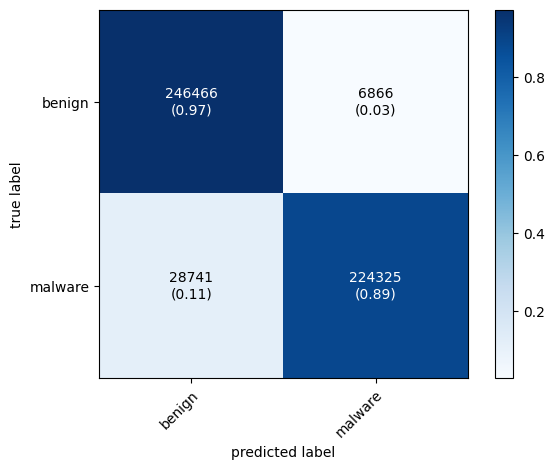

In [126]:
logreg_cm = confusion_matrix(y_test, logreg_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=logreg_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["benign", "malware"])
save_fig("logistic_regression_pred_test_confusion_matrix")
plt.show()

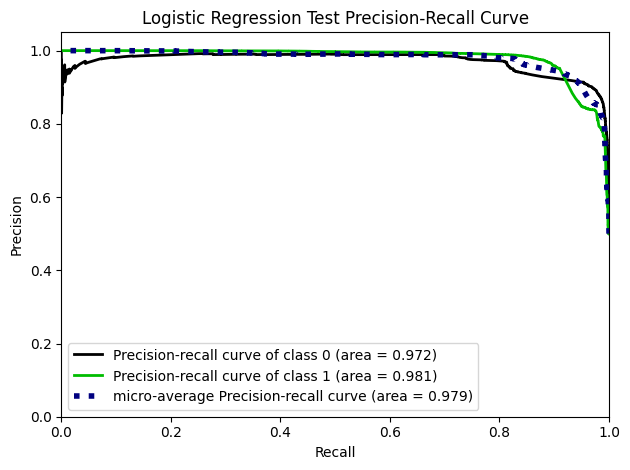

In [127]:
plot_precision_recall(y_test, logreg_test_proba, title="Logistic Regression Test Precision-Recall Curve")
save_fig("logistic_regression_test_precision_recall_curve")
plt.show()

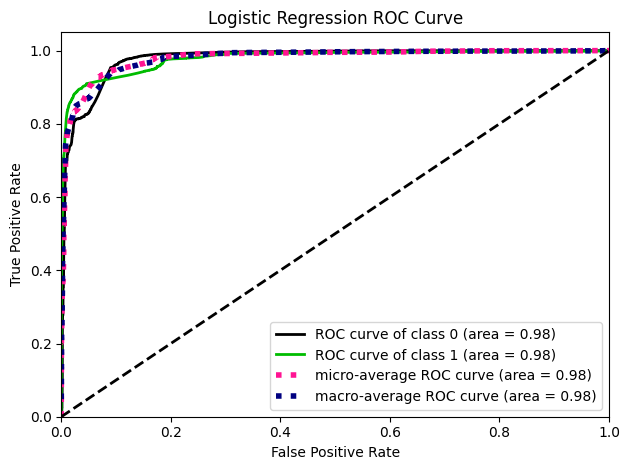

In [128]:
plot_roc_curve(y_test, logreg_test_proba, title="Logistic Regression ROC Curve")
save_fig("logistic_regression_roc_curve")
plt.show()

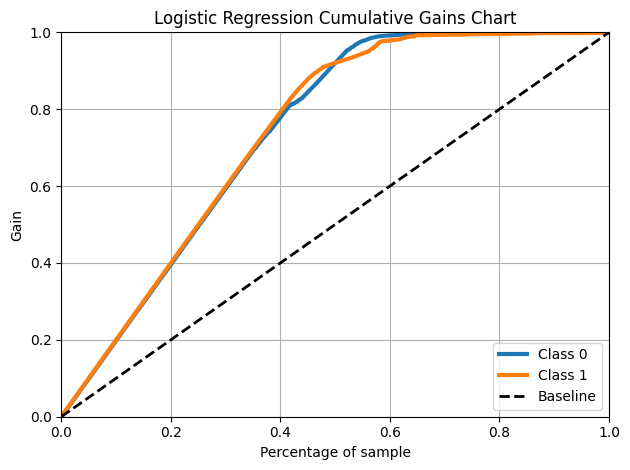

In [129]:
plot_cumulative_gain(y_test, logreg_test_proba, title="Logistic Regression Cumulative Gains Chart")
save_fig("logistic_regression_cumulative_gains")
plt.show()

# Random Forest

* Random forests, also known as random choice forests, are an ensemble learning approach for classification, regression, and other problems that works by building a large number of decision trees during training. For classification problems, the random forest output is the class chosen by the majority of trees.

In [131]:
rf = RandomForestClassifier()
start = time.time()
rf.fit(X_train, y_train)
end = time.time()
rf_time = end - start
print("Random Forest Train Time:", rf_time)

Random Forest Train Time: 303.30101442337036


In [132]:
pickle.dump(rf, open("waf/website/models/rf.pkl", "wb"))

In [158]:
rf_scores = cross_val_score(RandomForestClassifier(), X_train, y_train, cv=3)
print("Random Forest Cross-Validation Accuracy Scores:\n", rf_scores)

Random Forest Cross-Validation Accuracy Scores:
 [0.96694433 0.96700649 0.96719311]


In [133]:
rf_pred_train = rf.predict(X_train)
rf_pred_test = rf.predict(X_test)
rf_test_proba = rf.predict_proba(X_test)

rf_train_score = accuracy_score(rf_pred_train, y_train)
rf_test_score = accuracy_score(rf_pred_test, y_test)
print("Random Forest Train Score:", rf_train_score)
print("Random Forest Test Score:", rf_test_score)

Random Forest Train Score: 0.9693936087757147
Random Forest Test Score: 0.9684200964458786


In [134]:
rf_precision_score = precision_score(y_test, rf_pred_test)
rf_f1_score = f1_score(y_test, rf_pred_test)
rf_recall_score = recall_score(y_test, rf_pred_test)
rf_accuracy_score = accuracy_score(y_test, rf_pred_test)

print("Random Forest Precision Score:", rf_precision_score)
print("Random Forest F1 Score:", rf_f1_score)
print("Random Forest Recall Score:", rf_recall_score)
print("Random Forest Accuracy Score:", rf_accuracy_score)

Random Forest Precision Score: 0.9925210035151284
Random Forest F1 Score: 0.9676104832502936
Random Forest Recall Score: 0.943919767965669
Random Forest Accuracy Score: 0.9684200964458786


In [150]:
print(classification_report(y_test, rf_pred_test, target_names=["benign", "malware"]))

              precision    recall  f1-score   support

      benign       0.95      0.99      0.97    253332
     malware       0.99      0.94      0.97    253066

    accuracy                           0.97    506398
   macro avg       0.97      0.97      0.97    506398
weighted avg       0.97      0.97      0.97    506398



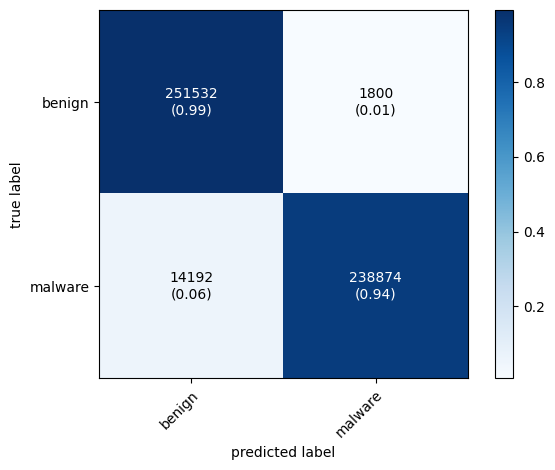

In [136]:
rf_cm = confusion_matrix(y_test, rf_pred_test)
plot_confusion_matrix(conf_mat=rf_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["benign", "malware"])
save_fig("random_forest_pred_test_confusion_matrix")
plt.show()

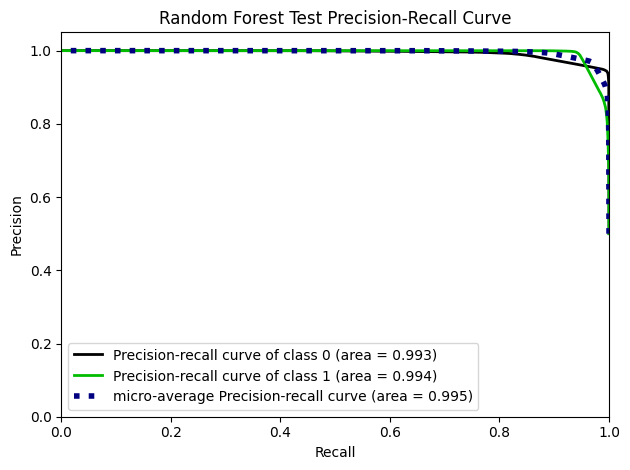

In [137]:
plot_precision_recall(y_test, rf_test_proba, title="Random Forest Test Precision-Recall Curve")
save_fig("random_forest_test_precision_recall_curve")
plt.show()

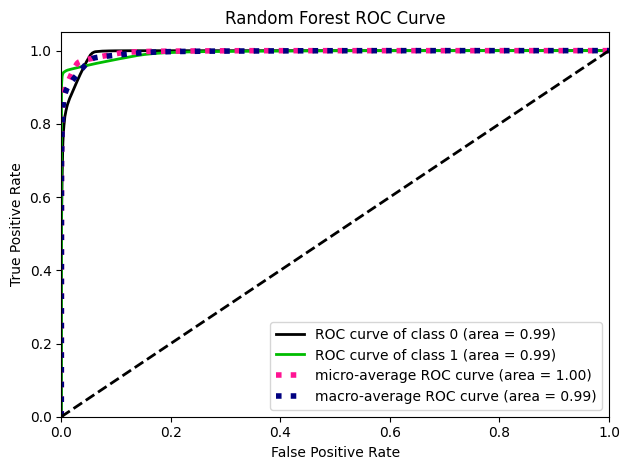

In [138]:
plot_roc_curve(y_test, rf_test_proba, title="Random Forest ROC Curve")
save_fig("random_forest_roc_curve")
plt.show()

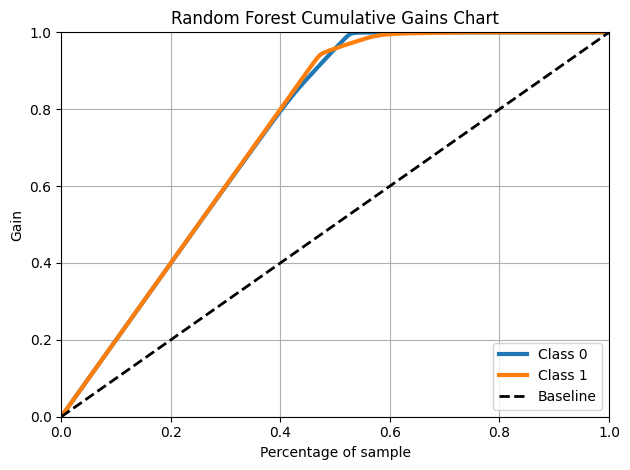

In [139]:
plot_cumulative_gain(y_test, rf_test_proba, title="Random Forest Cumulative Gains Chart")
save_fig("random_forest_cumulative_gains")
plt.show()

In [140]:
for name, score in zip(X.columns, rf.feature_importances_):
    print(name, score)

is_xss 0.05687205195741806
is_lfi 0.0015714978155853677
is_oci 0.030948920036647908
is_sqli 0.00016420320353315788
url_len 0.23662847433419634
semicolon_count 0.004602123019461626
underscore_count 0.00935887718878421
questionmark_count 0.04939923179209457
equal_count 0.09895647621705479
and_count 0.06016750489476494
or_count 0.006001029157789798
dot_count 0.04813083315323141
at_count 0.0021138470610644103
subdir_count 0.01918931253948927
query_len 0.03874807941790319
param_count 0.014522895778565918
total_digits_url 0.01906530212146111
total_letter_url 0.13495598618985818
total_digits_domain 0.0024513199093556693
total_letter_domain 0.04091516066418713
total_digits_path 0.010460586931260079
total_letter_path 0.05184138135569114
has_extension 0.015614444905923354
has_parameter 0.04732046035467837


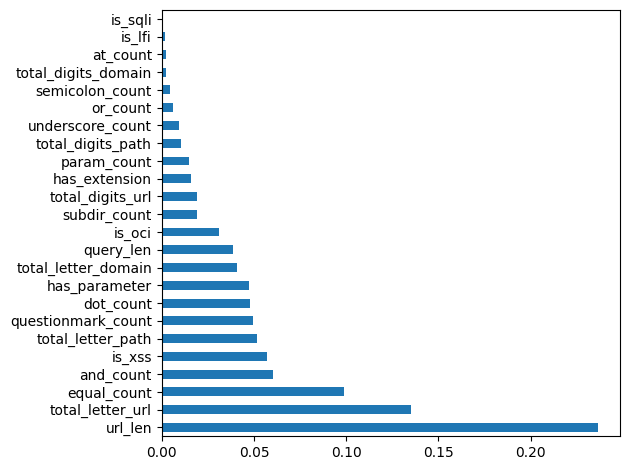

In [141]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')
save_fig("rf_feature_importances")
plt.show()

# Decision Tree

* A decision tree is a flowchart-like structure where each leaf node represents a class label (decision made after computing all attributes) and each internal node represents a "test" on an attribute (such as whether a coin flips heads or tails).

In [142]:
dt = DecisionTreeClassifier()
start = time.time()
dt.fit(X_train, y_train)
end = time.time()
dt_time = end - start
print("Decision Tree Train Time:", dt_time)

Decision Tree Train Time: 16.59295630455017


In [143]:
pickle.dump(dt, open("waf/website/models/dt.pkl", "wb"))

In [171]:
dt_scores = cross_val_score(DecisionTreeClassifier(), X_train, y_train, cv=3)
print("Decision Tree Cross-Validation Accuracy Scores:\n", dt_scores)

Decision Tree Cross-Validation Accuracy Scores:
 [0.96653109 0.96680802 0.96692651]


In [144]:
dt_pred_train = dt.predict(X_train)
dt_pred_test = dt.predict(X_test)
dt_test_proba = dt.predict_proba(X_test)

dt_train_score = accuracy_score(dt_pred_train, y_train)
dt_test_score = accuracy_score(dt_pred_test, y_test)
print("Decision Tree Train Score:", dt_train_score)
print("Decision Tree Test Score:", dt_test_score)

Decision Tree Train Score: 0.9693941024590367
Decision Tree Test Score: 0.9683193851476507


In [145]:
dt_precision_score = precision_score(y_test, dt_pred_test)
dt_f1_score = f1_score(y_test, dt_pred_test)
dt_recall_score = recall_score(y_test, dt_pred_test)
dt_accuracy_score = accuracy_score(y_test, dt_pred_test)

print("Decision Tree Precision Score:", dt_precision_score)
print("Decision Tree F1 Score:", dt_f1_score)
print("Decision Tree Recall Score:", dt_recall_score)
print("Decision Tree Accuracy Score:", dt_accuracy_score)

Decision Tree Precision Score: 0.9928102428050449
Decision Tree F1 Score: 0.9674944838080263
Decision Tree Recall Score: 0.9434376802889365
Decision Tree Accuracy Score: 0.9683193851476507


In [152]:
print(classification_report(y_test, dt_pred_test, target_names=["benign", "malware"]))

              precision    recall  f1-score   support

      benign       0.95      0.99      0.97    253332
     malware       0.99      0.94      0.97    253066

    accuracy                           0.97    506398
   macro avg       0.97      0.97      0.97    506398
weighted avg       0.97      0.97      0.97    506398



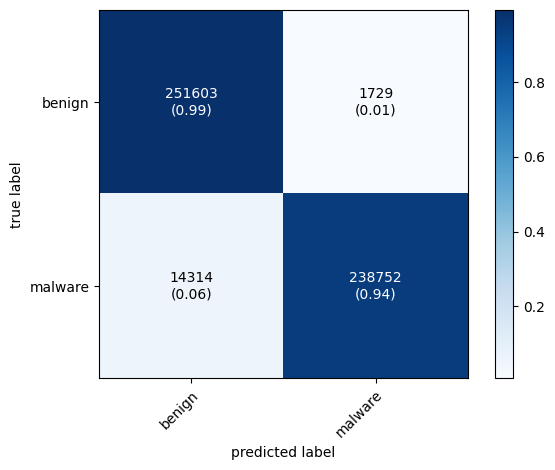

In [153]:
dt_cm = confusion_matrix(y_test, dt_pred_test)
plot_confusion_matrix(conf_mat=dt_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["benign", "malware"])
save_fig("decision_tree_pred_test_confusion_matrix")
plt.show()

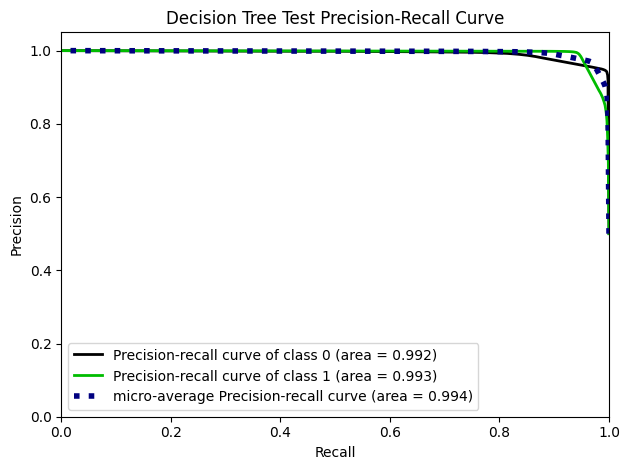

In [155]:
plot_precision_recall(y_test, dt_test_proba, title="Decision Tree Test Precision-Recall Curve")
save_fig("decision_tree_test_precision_recall_curve")
plt.show()

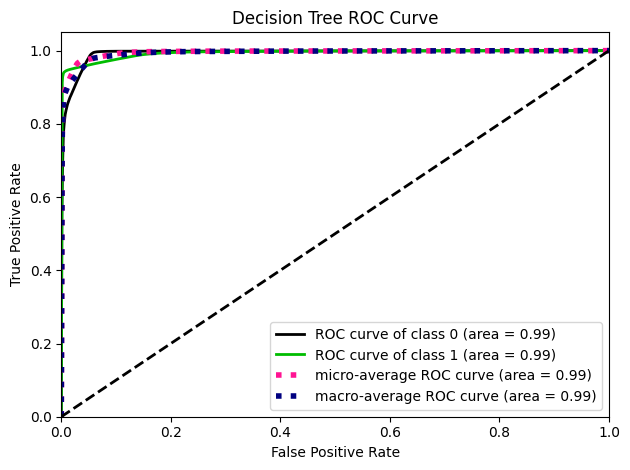

In [156]:
plot_roc_curve(y_test, dt_test_proba, title="Decision Tree ROC Curve")
save_fig("decision_tree_roc_curve")
plt.show()

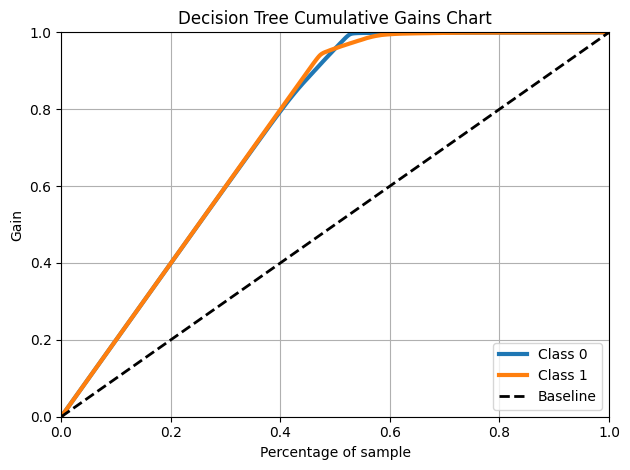

In [157]:
plot_cumulative_gain(y_test, dt_test_proba, title="Decision Tree Cumulative Gains Chart")
save_fig("decision_tree_cumulative_gains")
plt.show()

# XGBClassifier

* The XGBoost Classifier is a powerful and versatile machine learning algorithm that belongs to the gradient boosting family. It is widely used for classification tasks in both binary and multiclass scenarios.

In [158]:
xgb = XGBClassifier()
start = time.time()
xgb.fit(X_train, y_train)
end = time.time()
xgb_time = end - start
print("XGBClassifier Train Time:", xgb_time)

XGBClassifier Train Time: 7.1751015186309814


In [159]:
pickle.dump(xgb, open("waf/website/models/xgb.pkl", "wb"))

In [160]:
xgb_scores = cross_val_score(XGBClassifier(), X_train, y_train, cv=3)
print("XGBClassifier Cross-Validation Accuracy Scores:\n", xgb_scores)

XGBClassifier Cross-Validation Accuracy Scores:
 [0.96158306 0.96168526 0.96154894]


In [161]:
xgb_pred_train = xgb.predict(X_train)
xgb_pred_test = xgb.predict(X_test)
xgb_test_proba = xgb.predict_proba(X_test)

xgb_train_score = accuracy_score(xgb_pred_train, y_train)
xgb_test_score = accuracy_score(xgb_pred_test, y_test)
print("XGBClassifier Train Score:", xgb_train_score)
print("XGBClassifier Test Score:", xgb_test_score)

XGBClassifier Train Score: 0.9622574163577032
XGBClassifier Test Score: 0.961899533568458


In [162]:
xgb_precision_score = precision_score(y_test, xgb_pred_test)
xgb_f1_score = f1_score(y_test, xgb_pred_test)
xgb_recall_score = recall_score(y_test, xgb_pred_test)
xgb_accuracy_score = accuracy_score(y_test, xgb_pred_test)

print("XGBClassifier Precision Score:", xgb_precision_score)
print("XGBClassifier F1 Score:", xgb_f1_score)
print("XGBClassifier Recall Score:", xgb_recall_score)
print("XGBClassifier Accuracy Score:", xgb_accuracy_score)

XGBClassifier Precision Score: 0.9860892781395814
XGBClassifier F1 Score: 0.9609059668347085
XGBClassifier Recall Score: 0.9369769151130535
XGBClassifier Accuracy Score: 0.961899533568458


In [163]:
print(classification_report(y_test, xgb_pred_test, target_names=["benign", "malware"]))

              precision    recall  f1-score   support

      benign       0.94      0.99      0.96    253332
     malware       0.99      0.94      0.96    253066

    accuracy                           0.96    506398
   macro avg       0.96      0.96      0.96    506398
weighted avg       0.96      0.96      0.96    506398



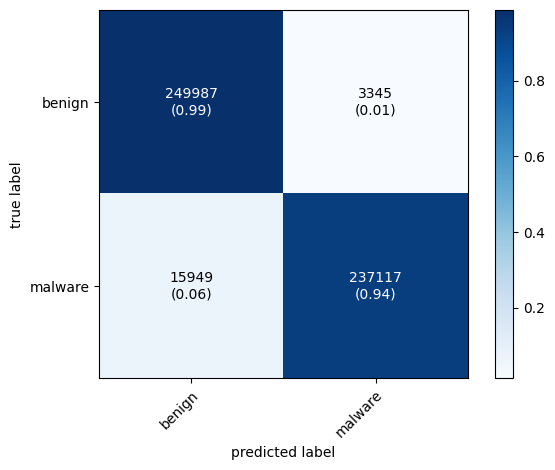

In [165]:
xgb_cm = confusion_matrix(y_test, xgb_pred_test)
plot_confusion_matrix(conf_mat=xgb_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["benign", "malware"])
save_fig("xgb_pred_test_confusion_matrix")
plt.show()

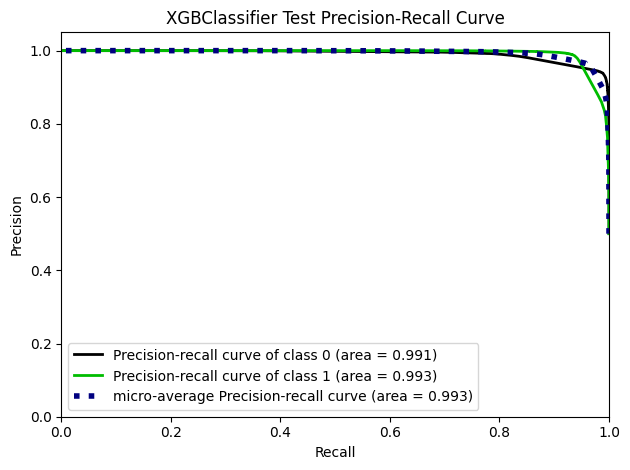

In [167]:
plot_precision_recall(y_test, xgb_test_proba, title="XGBClassifier Test Precision-Recall Curve")
save_fig("xgb_test_precision_recall_curve")
plt.show()

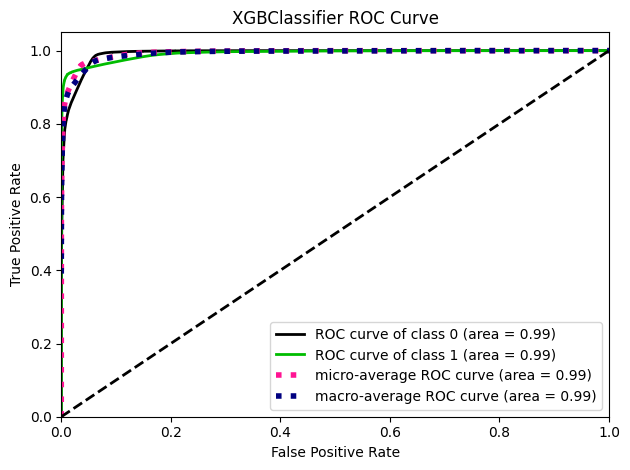

In [168]:
plot_roc_curve(y_test, xgb_test_proba, title="XGBClassifier ROC Curve")
save_fig("xgb_roc_curve")
plt.show()

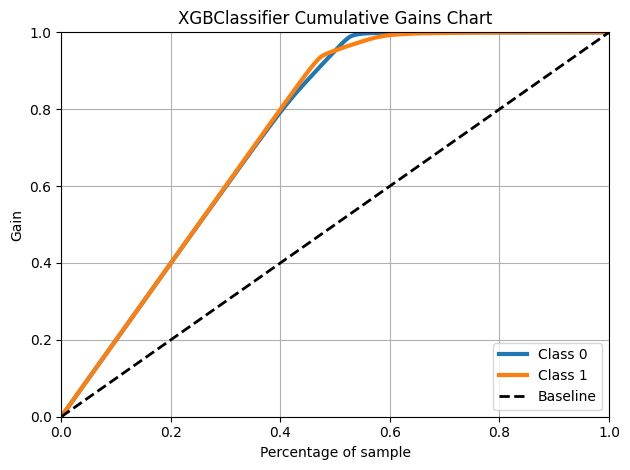

In [170]:
plot_cumulative_gain(y_test, xgb_test_proba, title="XGBClassifier Cumulative Gains Chart")
save_fig("xgb_cumulative_gains")
plt.show()

In [171]:
labels = ["LR", "DT", "RF", "XGB"]
scores = [logreg_test_score, dt_test_score, rf_test_score, xgb_test_score]

In [172]:
def plot_model_plot(labels, scores):
    plt.figure()
    ax = sns.barplot(x=labels, y=scores)
    ax.set_title("Trained Models Accuracy")
    for container in ax.containers:
        ax.bar_label(container)

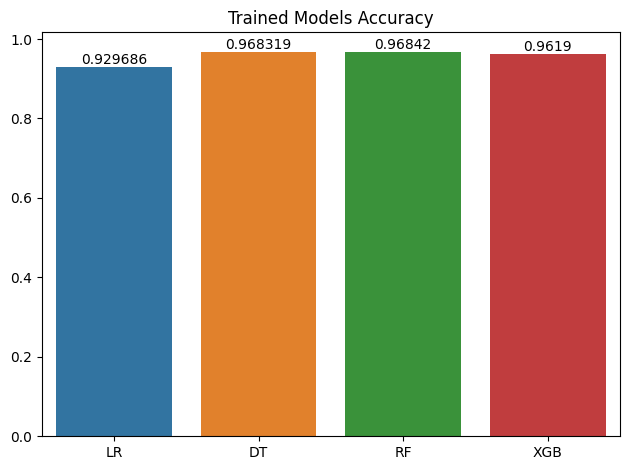

In [173]:
plot_model_plot(labels, scores)
save_fig("trained_models")
plt.show()

###### Çeşitli model testleri yaptıktan sonra, Rastgele Orman'ın diğerlerinden daha iyi performans gösterdiğini ve tutarlı bir şekilde 0,991173 puan elde ettiğini görüyoruz.

In [174]:
df.head()

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension,has_parameter,parameters
0,sbook1f,0,0,0,0,0,7,0,0,0,...,"[sbook, f]",sbook,0,0,1,6,0,,0,
1,376491,0,0,0,0,0,6,0,0,0,...,[],,0,0,6,0,0,,0,
2,51310374,0,0,0,0,0,8,0,0,0,...,[],,0,0,8,0,0,,0,
3,juliobrasil3,0,0,0,0,0,12,0,0,0,...,[juliobrasil],juliobrasil,0,0,1,11,0,,0,
4,08hearing,0,0,0,0,0,9,0,0,0,...,[hearing],hear,0,0,2,7,0,,0,


# Test

In [175]:
columns = ['query', 'is_xss', 'is_lfi', 'is_oci', 'is_sqli', 'url_len',
       'semicolon_count', 'underscore_count', 'questionmark_count',
       'equal_count', 'and_count', 'or_count', 'dot_count', 'at_count',
       'subdir_count', 'query_len', 'param_count', 'total_digits_url',
       'total_letter_url', 'total_digits_domain', 'total_letter_domain', 
       'total_digits_path', 'total_letter_path', 'has_extension', 'has_parameter']

In [187]:
test1 = 'hrttz9fj.dll?<script>document.cookie="testtbjy=7334;"</script>' # 1
test2 = 'index.php?option=com_mailto&tmpl=component&link=aHR0cDovL2FkdmVudHVyZ' # 1
test3 = 'nba/player/_/id/3457/brandon-rush' # 0
test4 = '?q=anthony-hamilton-soulife' # 0
test5 = 'site/relationship_detail.php?name=Martin-Brodeur&celebid=12150&relid=11371;cat /etc/passwd' # 1

In [188]:
test_df = pd.DataFrame(columns=columns)

In [189]:
test_df.loc[0, "query"] = test1
test_df.loc[1, "query"] = test2
test_df.loc[2, "query"] = test3
test_df.loc[3, "query"] = test4
test_df.loc[4, "query"] = test5

In [190]:
test_df.head()

,query,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,...,query_len,param_count,total_digits_url,total_letter_url,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,has_parameter
0,"hrttz9fj.dll?<script>document.cookie=""testtbjy...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,index.php?option=com_mailto&tmpl=component&lin...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,nba/player/_/id/3457/brandon-rush,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,?q=anthony-hamilton-soulife,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,site/relationship_detail.php?name=Martin-Brode...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [191]:
stemmer = SnowballStemmer("english")
tokenizer = RegexpTokenizer(r"[A-Za-z]+")

In [192]:
def preprocess(test_df):
    test_df["query"] = test_df["query"].apply(clear_first_char)
    test_df["is_xss"] = test_df["query"].apply(xss_check)
    test_df["is_lfi"] = test_df["query"].apply(lfi_check)
    test_df["is_oci"] = test_df["query"].apply(command_injection_check)
    test_df["is_sqli"] = test_df["query"].apply(sql_injection_check)
    test_df["url_len"] = test_df["query"].apply(urllen)
    test_df["semicolon_count"] = test_df["query"].apply(semicolon_count)
    test_df["underscore_count"] = test_df["query"].apply(underscore_count)
    test_df["questionmark_count"] = test_df["query"].apply(questionmark_count)
    test_df["equal_count"] = test_df["query"].apply(equal_count)
    test_df["and_count"] = test_df["query"].apply(and_count)
    test_df["or_count"] = test_df["query"].apply(or_count)
    test_df["dot_count"] = test_df["query"].apply(dotcount)
    test_df["at_count"] = test_df["query"].apply(atcount)
    test_df["subdir_count"] = test_df["query"].apply(subdircount)
    test_df["query_len"] = test_df["query"].apply(query_len)
    test_df["param_count"] = test_df["query"].apply(param_count)
    test_df["total_digits_url"] = test_df["query"].apply(total_digits_in_url)
    test_df["total_letter_url"] = test_df["query"].apply(total_letter_in_url)
    test_df["url_tokenized"] = test_df["query"].apply(lambda x: tokenizer.tokenize(x))
    test_df["url_stemmed"] = test_df["url_tokenized"].apply(stem_url)
    test_df["total_digits_domain"] = test_df["query"].apply(total_digits_domain)
    test_df["total_letter_domain"] = test_df["query"].apply(total_letter_domain)
    test_df["total_digits_path"] = test_df["query"].apply(total_digits_path)
    test_df["total_letter_path"] = test_df["query"].apply(total_letter_path)
    test_df["has_extension"] = test_df["query"].apply(has_extension)
    test_df["extension"] = test_df["query"].apply(find_extension)
    test_df["has_parameter"] = test_df["query"].apply(has_parameter)
    test_df["parameters"] = test_df["query"].apply(find_parameter_name)
    return test_df

In [193]:
test_df = preprocess(test_df)

In [194]:
test_df.head()

,query,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,...,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,has_parameter,url_tokenized,url_stemmed,extension,parameters
0,"hrttz9fj.dll?<script>document.cookie=""testtbjy...",1,0,1,0,62,1,0,1,2,...,0,0,1,10,1,1,"[hrttz, fj, dll, script, document, cookie, tes...",hrttz dll script document cooki testtbji script,.dll,<script>document.cookie
1,index.php?option=com_mailto&tmpl=component&lin...,0,0,0,0,69,0,1,1,3,...,0,0,0,8,1,1,"[index, php, option, com, mailto, tmpl, compon...",index php option com mailto tmpl compon link a...,.php,option tmpl link
2,nba/player/_/id/3457/brandon-rush,0,0,0,0,33,0,1,0,0,...,4,11,0,11,0,0,"[nba, player, id, brandon, rush]",nba player brandon rush,,
3,?q=anthony-hamilton-soulife,0,0,0,0,27,0,0,1,1,...,0,0,0,0,0,1,"[q, anthony, hamilton, soulife]",anthoni hamilton soulif,,q
4,site/relationship_detail.php?name=Martin-Brode...,0,0,1,0,90,1,1,1,3,...,0,4,0,21,1,1,"[site, relationship, detail, php, name, Martin...",site relationship detail php name martin brode...,.php,name celebid relid


In [195]:
dropped = test_df.drop(["query", "url_tokenized", "url_stemmed", "extension", "parameters"], axis=1)

In [196]:
dropped_scaled = ss.transform(dropped)

In [197]:
logreg.predict(dropped_scaled)

array([1, 1, 1, 0, 1])